In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib as tf_contrib
import os
import glob
import matplotlib.pyplot as plt
import imageio
import time
import re
from  skimage import color

In [2]:
"""Implementation of tensorflow image ops."""
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import nn_ops


def convert_image_dtype(
    image,
    dtype,
    saturate=False,
    name=None,
    ):

    image = ops.convert_to_tensor(image, name='image')
    if dtype == image.dtype:
        return array_ops.identity(image, name=name)

    with ops.name_scope(name, 'convert_image', [image]) as name:
        if image.dtype.is_integer and dtype.is_integer:
            scale_in = image.dtype.max
            scale_out = dtype.max
            if scale_in > scale_out:
                scale = (scale_in + 1) // (scale_out + 1)
                scaled = math_ops.div(image, scale)
                if saturate:
                    return math_ops.saturate_cast(scaled, dtype,
                            name=name)
                else:
                    return math_ops.cast(scaled, dtype, name=name)
            else:
                if saturate:
                    cast = math_ops.saturate_cast(image, dtype)
                else:
                    cast = math_ops.cast(image, dtype)
                scale = (scale_out + 1) // (scale_in + 1)
                return math_ops.multiply(cast, scale, name=name)
        elif image.dtype.is_floating and dtype.is_floating:
            return math_ops.cast(image, dtype, name=name)
        else:
            if image.dtype.is_integer:
                cast = math_ops.cast(image, dtype)
                scale = 1. / image.dtype.max
                return math_ops.multiply(cast, scale, name=name)
            else:
                scale = dtype.max + 0.5  # avoid rounding problems in the cast
                scaled = math_ops.multiply(image, scale)
                if saturate:
                    return math_ops.saturate_cast(scaled, dtype,
                            name=name)
                else:
                    return math_ops.cast(scaled, dtype, name=name)

def _verify_compatible_image_shapes(img1, img2):
    shape1 = img1.get_shape().with_rank_at_least(3)
    shape2 = img2.get_shape().with_rank_at_least(3)
    shape1[-3:].assert_is_compatible_with(shape2[-3:])

    if shape1.ndims is not None and shape2.ndims is not None:
        for (dim1, dim2) in zip(reversed(shape1[:-3]),
                                reversed(shape2[:-3])):
            if not (dim1 == 1 or dim2 == 1
                    or dim1.is_compatible_with(dim2)):
                raise ValueError('Two images are not compatible: %s and %s'
                                  % (shape1, shape2))

    (shape1, shape2) = array_ops.shape_n([img1, img2])
    checks = []
    checks.append(control_flow_ops.Assert(math_ops.greater_equal(array_ops.size(shape1),
                  3), [shape1, shape2], summarize=10))
    checks.append(control_flow_ops.Assert(math_ops.reduce_all(math_ops.equal(shape1[-3:],
                  shape2[-3:])), [shape1, shape2], summarize=10))
    return (shape1, shape2, checks)

_SSIM_K1 = 0.01
_SSIM_K2 = 0.03

def _ssim_helper(
    x,
    y,
    reducer,
    max_val,
    gamma,
    beta,
    compensation=1.0,
    ):

    c1 = (_SSIM_K1 * max_val) ** 2
    c2 = (_SSIM_K2 * max_val) ** 2
    mean0 = reducer(x)
    mean1 = reducer(y)
    num0 = mean0 * mean1 * 2.0
    den0 = math_ops.square(mean0) + math_ops.square(mean1)
    luminance = (num0 + c1) / (den0 + c1)
    luminance = luminance ** gamma
    num1 = reducer(x * y) * 2.0
    den1 = reducer(math_ops.square(x) + math_ops.square(y))
    c2 *= compensation
    cs = (num1 - num0 + c2) / (den1 - den0 + c2)
    cs = cs ** beta
    return (luminance, cs)


def _fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function."""

    size = ops.convert_to_tensor(size, dtypes.int32)
    sigma = ops.convert_to_tensor(sigma)
    coords = math_ops.cast(math_ops.range(size), sigma.dtype)
    coords -= math_ops.cast(size - 1, sigma.dtype) / 2.0
    g = math_ops.square(coords)
    g *= -0.5 / math_ops.square(sigma)
    g = array_ops.reshape(g, shape=[1, -1]) + array_ops.reshape(g,
            shape=[-1, 1])
    g = array_ops.reshape(g, shape=[1, -1])  # For tf.nn.softmax().
    g = nn_ops.softmax(g)
    return array_ops.reshape(g, shape=[size, size, 1, 1])



def _ssim_per_channel(img1, img2, gamma, beta, max_val=1.0):
    filter_size = constant_op.constant(11, dtype=dtypes.int32)
    filter_sigma = constant_op.constant(1.5, dtype=img1.dtype)

    (shape1, shape2) = array_ops.shape_n([img1, img2])
    checks = \
        [control_flow_ops.Assert(math_ops.reduce_all(math_ops.greater_equal(shape1[-3:-1],
         filter_size)), [shape1, filter_size], summarize=8),
         control_flow_ops.Assert(math_ops.reduce_all(math_ops.greater_equal(shape2[-3:-1],
         filter_size)), [shape2, filter_size], summarize=8)]
    with ops.control_dependencies(checks):
        img1 = array_ops.identity(img1)
    kernel = _fspecial_gauss(filter_size, filter_sigma)
    kernel = array_ops.tile(kernel, multiples=[1, 1, shape1[-1], 1])

    compensation = 1.0
    def reducer(x):
        shape = array_ops.shape(x)
        x = array_ops.reshape(x, shape=array_ops.concat([[-1],
                              shape[-3:]], 0))
        y = nn.depthwise_conv2d(x, kernel, strides=[1, 1, 1, 1],
                                padding='VALID')
        return array_ops.reshape(y, array_ops.concat([shape[:-3],
                                 array_ops.shape(y)[1:]], 0))

    (luminance, cs) = _ssim_helper(img1, img2, reducer, max_val, gamma, beta,
                                   compensation)
    axes = constant_op.constant([-3, -2], dtype=dtypes.int32)
    ssim_val = math_ops.reduce_mean(luminance * cs, axes)
    cs = math_ops.reduce_mean(cs, axes)
    return (ssim_val, cs)


def ssim(img1, img2, gamma, beta, max_val):
    (_, _, checks) = _verify_compatible_image_shapes(img1, img2)
    with ops.control_dependencies(checks):
        img1 = array_ops.identity(img1)
    max_val = math_ops.cast(max_val, img1.dtype)
    max_val = convert_image_dtype(max_val, dtypes.float32)
    img1 = convert_image_dtype(img1, dtypes.float32)
    img2 = convert_image_dtype(img2, dtypes.float32)
    (ssim_per_channel, _) = _ssim_per_channel(img1, img2, gamma, beta, max_val)

  # Compute average over color channels.
    return math_ops.reduce_mean(ssim_per_channel, [-1])


In [3]:
#define parameters
image_length = 256
image_width  = 256
gray_channels = 1   
batch_size   = 1
epoch = 20
lr = 0.002
alpha = 1

In [4]:
#search and pre-process the input MRI dataset
filenames = os.listdir('/home/caibadal/Desktop/Thesis/DataGray/Training/MR-T2/')
dataset = os.path.join(os.getcwd(), '/home/caibadal/Desktop/Thesis/DataGray/Training/MR-T2/')
data = []
for ext in ('*.gif', '*.png', '*.jpg','*.tif'):
    data.extend(glob.glob(os.path.join(dataset, ext)))
data.sort(key=lambda x:int(filter(str.isdigit, x)))
train_mri = np.zeros((len(data), image_width,image_length))
for i in xrange(len(data)):
    train_mri[i,:,:] =(imageio.imread(data[i]))
    train_mri[i,:,:] = np.float32(train_mri[i,:,:])

In [5]:
#Normalize the MRI Dataset
train_mri = train_mri / 255

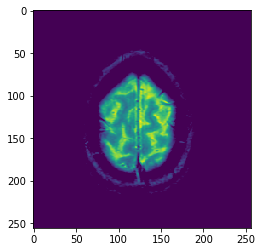

In [6]:
plt.imshow(train_mri[22,:,:])

In [7]:
train_mri = train_mri[:,:,:,np.newaxis]
train_mri.shape

(502, 256, 256, 1)

In [8]:
#search and pre-process the other input modality dataset
filenames = os.listdir('/home/caibadal/Desktop/Thesis/DataGray/Training/Other/')
dataset = os.path.join(os.getcwd(), '/home/caibadal/Desktop/Thesis/DataGray/Training/Other/')
data = []
for ext in ('*.gif', '*.png', '*.jpg','*.tif'):
    data.extend(glob.glob(os.path.join(dataset, ext)))
data.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
train_oth = np.zeros((len(data),image_width,image_length))
for i in xrange(len(data)):
    train_oth[i,:,:] =(imageio.imread(data[i]))
    train_oth[i,:,:] = np.float32(train_oth[i,:,:])

In [9]:
#Normalize the other modality Dataset
train_oth = train_oth / 255

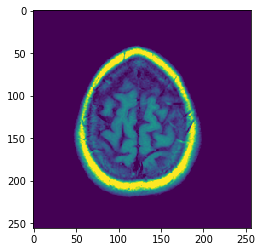

In [10]:
plt.imshow(train_oth[22,:,:])

In [11]:
train_oth = train_oth[:,:,:,np.newaxis]
train_oth.shape

(502, 256, 256, 1)

In [12]:
#define placeholders for input modalities
images_oth   = tf.placeholder(tf.float32, [None, image_width,image_length,gray_channels],name='images_oth')
images_mri   = tf.placeholder(tf.float32, [None, image_width,image_length,gray_channels],name ='images_mri')
input_image = tf.concat([images_mri,images_oth],axis=-1) #input as concat of thermal and visible images

In [13]:
#define CNN network
def network(img):
    with tf.variable_scope('network'):
        with tf.variable_scope('layer1'):
            weights=tf.get_variable("w1",[5,5,2,128],initializer=tf.truncated_normal_initializer(stddev=1e-3))
            bias=tf.get_variable("b1",[128],initializer=tf.constant_initializer(0.0))
            conv1= tf.contrib.layers.batch_norm(tf.nn.conv2d(img, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv1 = tf.maximum(conv1, 0.2 * conv1) #Leaky RELU
        with tf.variable_scope('layer2'):
            weights=tf.get_variable("w2",[5,5,128,64],initializer=tf.truncated_normal_initializer(stddev=1e-3))
            bias=tf.get_variable("b2",[64],initializer=tf.constant_initializer(0.0))
            conv2= tf.contrib.layers.batch_norm(tf.nn.conv2d(conv1, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv2 = tf.maximum(conv2, 0.2 * conv2) #Leaky RELU
        with tf.variable_scope('layer3'):
            weights=tf.get_variable("w3",[3,3,64,32],initializer=tf.truncated_normal_initializer(stddev=1e-3))
            bias=tf.get_variable("b3",[32],initializer=tf.constant_initializer(0.0))
            conv3= tf.contrib.layers.batch_norm(tf.nn.conv2d(conv2, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv3 = tf.maximum(conv3, 0.2 * conv3) #Leaky RELU
        with tf.variable_scope('layer4'):
            weights=tf.get_variable("w4",[3,3,32,16],initializer=tf.truncated_normal_initializer(stddev=1e-3))
            bias=tf.get_variable("b4",[16],initializer=tf.constant_initializer(0.0))
            conv4= tf.contrib.layers.batch_norm(tf.nn.conv2d(conv3, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv4 = tf.maximum(conv4, 0.2 * conv4) #Leaky RELU
        with tf.variable_scope('layer5'):
            weights=tf.get_variable("w5",[1,1,16,1],initializer=tf.truncated_normal_initializer(stddev=1e-3))
            bias=tf.get_variable("b5",[1],initializer=tf.constant_initializer(0.0))
            conv5= tf.nn.conv2d(conv4, weights, strides=[1,1,1,1], padding='SAME') + bias
            conv5=tf.nn.tanh(conv5)
    return conv5


In [14]:
#define generator and discriminator models
fused_image = network(input_image)

In [15]:
#grad_mri_x , grad_mri_y = tf.image.image_gradients(images_mri)
#grad_mri = tf.sqrt(tf.square(grad_mri_x) + tf.square(grad_mri_y))

In [16]:
#grad_fuse_x , grad_fuse_y = tf.image.image_gradients(fused_image)
#grad_fuse = tf.sqrt(tf.square(grad_fuse_x) + tf.square(grad_fuse_y))

In [17]:
mri_loss =  alpha * (1 - ssim(fused_image,images_mri, gamma = 4, beta=1, max_val=1.0)) 
oth_loss = alpha * (1 - ssim(fused_image,images_oth,  gamma = 4, beta=1, max_val=1.0))
ssim_loss = (mri_loss + oth_loss) # tryharmonic means and other to imporve the loss function

mri_l1_loss = (1 - alpha) * (tf.reduce_mean(tf.abs(fused_image - images_mri)))  
oth_l1_loss = (1 - alpha) * (tf.reduce_mean(tf.abs(fused_image - images_oth)))

l1_loss =  (mri_l1_loss + oth_l1_loss)

total_loss = ssim_loss + l1_loss

In [18]:
#define training variables and and optimizer function
t_vars = tf.trainable_variables()
G_vars = [var for var in t_vars if 'network' in var.name] 
#G_mri_optim = tf.train.AdamOptimizer(lr).minimize(mri_loss,  var_list= G_vars)
#G_oth_optim = tf.train.AdamOptimizer(lr).minimize(oth_loss,  var_list= G_vars)
#G_mri_l1_optim = tf.train.AdamOptimizer(lr).minimize(mri_l1_loss,  var_list= G_vars)
#G_oth_l1_optim = tf.train.AdamOptimizer(lr).minimize(oth_l1_loss,  var_list= G_vars)
#G_ssim_optim = tf.train.AdamOptimizer(lr).minimize(ssim_loss,  var_list= G_vars)
G_optim = tf.train.AdamOptimizer(lr).minimize(total_loss,  var_list= G_vars)

In [19]:
#start training
counter = 0
start_time = time.time()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
print("Training....")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for ep in xrange(epoch):
        #run batch images
        batch_idxs = len(data) // batch_size
        for idx in xrange(0, batch_idxs):
            batch_images_mri = train_mri[idx*batch_size : (idx+1)*batch_size,]
            batch_images_oth = train_oth[idx*batch_size : (idx+1)*batch_size,]
            counter += 1
            #run the session
            img, _, loss1, loss2, loss3, loss4, loss5  = sess.run([fused_image,
                                                                   G_optim,
                                                                    mri_loss,                                                       
                                                                    oth_loss,
                                                                    mri_l1_loss,
                                                                    oth_l1_loss,
                                                                    total_loss
                                                                     ], 
                                                            feed_dict={images_mri: batch_images_mri, 
                                                                       images_oth: batch_images_oth}
                                                     )
            if counter % 100 == 0:
                print("Epoch: [%2d],step: [%2d],time: [%4.4f], mri_loss: [%.8f], oth_loss: [%.8f], mri_l1_loss: [%.8f], oth_l1_loss: [%.8f], total_loss: [%.8f]"\
                      % ((ep+1), counter, time.time()-start_time, loss1, loss2, loss3, loss4, loss5))  
        if(ep == epoch -1):
            saver.save(sess, '/home/caibadal/Desktop/Thesis/DataGray/Atlas_brain/base_checkpoint/')

Training....
Epoch: [ 1],step: [100],time: [193.2678], mri_loss: [0.55840170], oth_loss: [0.47160906], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.03001070]
Epoch: [ 1],step: [200],time: [382.1850], mri_loss: [0.71267104], oth_loss: [0.67578250], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.38845348]
Epoch: [ 1],step: [300],time: [571.3614], mri_loss: [0.53138602], oth_loss: [0.54739511], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.07878113]
Epoch: [ 1],step: [400],time: [761.0246], mri_loss: [0.78328836], oth_loss: [0.88765681], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.67094517]
Epoch: [ 1],step: [500],time: [950.7598], mri_loss: [0.88520324], oth_loss: [0.94474953], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.82995272]
Epoch: [ 2],step: [600],time: [1140.7217], mri_loss: [0.79939967], oth_loss: [0.96945316], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000

Epoch: [10],step: [4900],time: [9309.1461], mri_loss: [0.89435083], oth_loss: [0.88867468], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.78302550]
Epoch: [10],step: [5000],time: [9499.2445], mri_loss: [0.82826054], oth_loss: [0.74456239], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.57282293]
Epoch: [11],step: [5100],time: [9689.1110], mri_loss: [0.75205934], oth_loss: [0.75069141], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.50275075]
Epoch: [11],step: [5200],time: [9878.7401], mri_loss: [0.56301904], oth_loss: [0.55673152], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.11975050]
Epoch: [11],step: [5300],time: [10068.7736], mri_loss: [0.74886978], oth_loss: [0.66839004], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.41725981]
Epoch: [11],step: [5400],time: [10258.4961], mri_loss: [0.83352137], oth_loss: [0.82556593], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000

Epoch: [20],step: [9700],time: [18439.4946], mri_loss: [0.63593036], oth_loss: [0.52507842], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.16100883]
Epoch: [20],step: [9800],time: [18629.5451], mri_loss: [0.89060950], oth_loss: [0.80795050], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.69856000]
Epoch: [20],step: [9900],time: [18819.8471], mri_loss: [0.84174019], oth_loss: [0.74142909], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.58316922]
Epoch: [20],step: [10000],time: [19010.3862], mri_loss: [0.60121977], oth_loss: [0.60598683], mri_l1_loss: [0.00000000], oth_l1_loss: [0.00000000], total_loss: [1.20720661]


In [20]:
len(data)

502

In [21]:
#load the test input MRI dataset
filenames = os.listdir('/home/caibadal/Desktop/Thesis/DataGray/Testing/MR-T2/')
dataset = os.path.join(os.getcwd(), '/home/caibadal/Desktop/Thesis/DataGray/Testing/MR-T2/')
data = []
for ext in ('*.gif', '*.png', '*.jpg','*.tif'):
    data.extend(glob.glob(os.path.join(dataset, ext)))
data.sort(key=lambda x:int(filter(str.isdigit, x)))
test_mri = np.zeros((len(data), image_width,image_length))
for i in xrange(len(data)):
    test_mri[i,:,:] =(imageio.imread(data[i]))
    test_mri[i,:,:] = np.float32(test_mri[i,:,:])
    
test_mri = test_mri[:,:,:,np.newaxis]


/home/caibadal/.local/lib/python2.7/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: 'module' object has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/caibadal/.local/lib/python2.7/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: 'module' object has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/caibadal/.local/lib/python2.7/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: 'module' object has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/caibadal/.local/lib/python2.7/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: 'module' object has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


In [22]:
data

['/home/caibadal/Desktop/Thesis/DataGray/Testing/MR-T2/010_MR-T2.tif']

In [23]:
test_mri.shape

(1, 256, 256, 1)

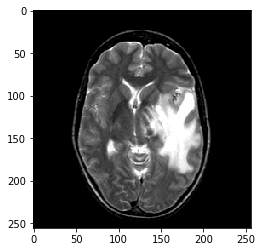

In [24]:
plt.imshow(test_mri[0,:,:,0],'gray')

In [25]:
#load the test input other modality dataset
filenames = os.listdir('/home/caibadal/Desktop/Thesis/DataGray/Testing/Other/')
dataset = os.path.join(os.getcwd(), '/home/caibadal/Desktop/Thesis/DataGray/Testing/Other/')
data = []
for ext in ('*.gif', '*.png', '*.jpg', '*.tif'):
    data.extend(glob.glob(os.path.join(dataset, ext)))
data.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
test_oth = np.zeros((len(data),image_width,image_length))
for i in xrange(len(data)):
    test_oth[i,:,:] =(imageio.imread(data[i]))
    test_oth[i,:,:] = np.float32(test_oth[i,:,:])
    
test_oth = test_oth[:,:,:,np.newaxis]

In [26]:
data 

['/home/caibadal/Desktop/Thesis/DataGray/Testing/Other/010_CT.tif']

In [27]:
test_oth.shape

(1, 256, 256, 1)

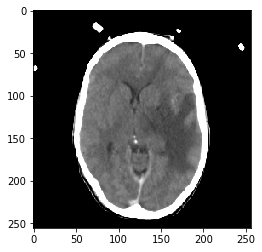

In [28]:
plt.imshow(test_oth[0,:,:,0],'gray')

In [29]:
#run the test session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, '/home/caibadal/Desktop/Thesis/DataGray/Atlas_brain/base_checkpoint/')
    img = sess.run(fused_image, feed_dict={images_mri: test_mri, 
                                           images_oth: test_oth}
                   )

INFO:tensorflow:Restoring parameters from /home/caibadal/Desktop/Thesis/DataGray/Atlas_brain/base_checkpoint/


In [30]:
img.shape

(1, 256, 256, 1)

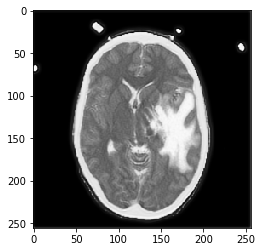

In [31]:
plt.imshow(img[0,:,:,0],'gray')

In [32]:
img = img[0,:,:,0] 
imageio.imwrite('/home/caibadal/Desktop/Thesis/Evaluation/CNNfusionbo.png',img)